In [1]:
import warnings
import time
import datetime
import sys
import numpy as np

from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import hmmlearn
from matplotlib.lines import Line2D
from hmmlearn import hmm

import random
import pandas as pd
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

pd.options.mode.use_inf_as_na = True

In [2]:
# Data Preprocessing: Transfer to Binary Situation
df = pd.read_csv('SP500.csv')

# Transfer column to list
date_list = pd.to_datetime(df['Date'])
volume_list = df['Volume']
open_list = df['Volume']
close_list = df['Close']

# Transfer everyday's closing prices' difference in percentage to Binary Variable
feature_1=np.diff(close_list)/close_list[:-1]
rise_or_drop = []

for i in range(0,17319):
    if feature_1[i] > 0: 
        rise_or_drop.append(1)
    else: rise_or_drop.append(0)
        
# Transfer everyday's volume prices' difference in percentage to Binary Variable
feature_2=np.diff(volume_list)/volume_list[:-1]
more_or_less = []

for i in range(0,17319):
    if feature_2[i] > 0: 
        more_or_less.append(1)
    else: more_or_less.append(0)

# Zip in a two-dimensional dataframe
x = pd.DataFrame(list(zip(rise_or_drop,more_or_less)), 
             columns = ['Rise or Drop','More or Less'],
            index = np.arange(1,17320,1))

In [3]:
df.shape

(17320, 7)

In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17315,2018-10-24,2737.870117,2742.590088,2651.889893,2656.100098,2656.100098,4709310000
17316,2018-10-25,2674.879883,2722.699951,2667.840088,2705.570068,2705.570068,4634770000
17317,2018-10-26,2667.860107,2692.379883,2628.159912,2658.689941,2658.689941,4803150000
17318,2018-10-29,2682.649902,2706.850098,2603.540039,2641.250000,2641.250000,4673700000
17319,2018-10-30,2640.679932,2685.429932,2635.340088,2682.629883,2682.629883,5106380000


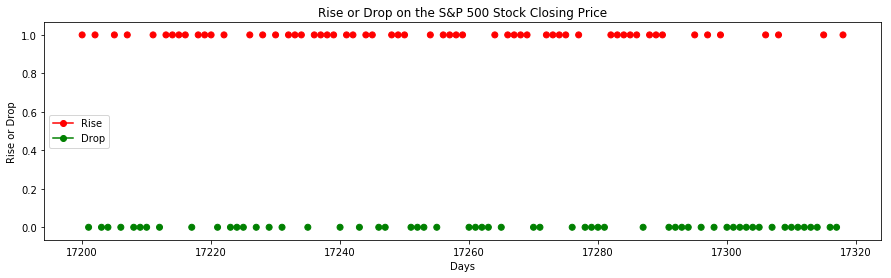

In [5]:
# Binary Variable Plot in recent 120 days
plt.figure(figsize=(15,4))
plt.title("Rise or Drop on the S&P 500 Stock Closing Price")
color= ['red' if i == 1 else 'green' for i in rise_or_drop[17200:17321]]
plt.scatter(np.arange(17200,17319,1),rise_or_drop[17200:17321],c=color)
plt.xlabel("Days")
plt.ylabel("Rise or Drop")
legend_elements = [Line2D([0], [0], color='r',marker='o',label='Rise'),
                   Line2D([0], [0], color='g',marker='o', label='Drop')]
plt.legend(handles=legend_elements,loc="center left")
plt.show()

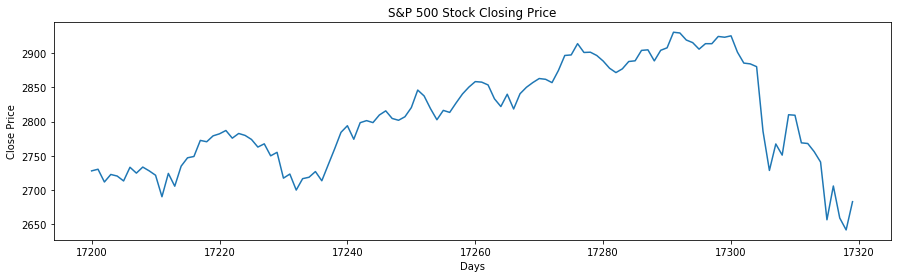

In [6]:
# Closing Price Plot in recent 120 days
plt.figure(figsize=(15,4))
plt.plot(close_list[17200:17321])
plt.title("S&P 500 Stock Closing Price")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.show()

In [7]:
# Set up with training and testing datasets
# First 56 years data which alomost 80% data will be training and rest 10 years will be testing
training = x[0:13670]
testing = x[13669:17320]
testing = testing.set_index(np.arange(1,3651,1))

In [8]:
# build HMM model
from hmmlearn.hmm import MultinomialHMM
model=hmm.MultinomialHMM(n_components=10, tol=1e-12, n_iter=1000)

## Traning Result

In [9]:
# Training Result
model = model.fit(training)

In [10]:
observe_window = np.arange(5,55,5)

for K in observe_window:
    
    iters = 0;
    past_likelihood = []
    while iters < 13670 - K:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(training[iters:iters + K])))
        iters = iters + 1
    
    likelihood_diff_idx_1 = []
    past_similar = []

    for i in range(13670 - K - 1,0,-1):
        curr_likelihood = model.score(training[i:i+K])
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
        past_similar.append(rise_or_drop[likelihood_diff_idx+K+1])
    
    cm = confusion_matrix(rise_or_drop[K:100+K],list(reversed(past_similar))[0:100])
    accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
    sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

    print("The Accuracy of Training set by 10-HMM prediction on", K, "days obeservation is", accuracy1)
    print("The Sensitivity of Training set by 10-HMM prediction on", K, "days obeservation is", sensitivity1)
    print("The Specificity of Training set by 10-HMM prediction on", K, "days obeservation is", specificity1)


The Accuracy of Training set by 10-HMM prediction on 5 days obeservation is 0.49
The Sensitivity of Training set by 10-HMM prediction on 5 days obeservation is 0.4444444444444444
The Specificity of Training set by 10-HMM prediction on 5 days obeservation is 0.5272727272727272
The Accuracy of Training set by 10-HMM prediction on 10 days obeservation is 0.51
The Sensitivity of Training set by 10-HMM prediction on 10 days obeservation is 0.4418604651162791
The Specificity of Training set by 10-HMM prediction on 10 days obeservation is 0.5614035087719298
The Accuracy of Training set by 10-HMM prediction on 15 days obeservation is 0.52
The Sensitivity of Training set by 10-HMM prediction on 15 days obeservation is 0.5111111111111111
The Specificity of Training set by 10-HMM prediction on 15 days obeservation is 0.5272727272727272
The Accuracy of Training set by 10-HMM prediction on 20 days obeservation is 0.54
The Sensitivity of Training set by 10-HMM prediction on 20 days obeservation is 0

## Testing

In [11]:
# Training Result
model = model.fit(testing)

In [12]:
observe_window = np.arange(5,55,5)

for K in observe_window:
    
    iters = 0;
    past_likelihood = []
    while iters < 3650 - K:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
        iters = iters + 1
    
    likelihood_diff_idx_1 = []
    past_similar_test = []

    for i in range(3650 - K - 1,0,-1):
        curr_likelihood = model.score(testing[i:i+K])
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
        past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])
    
    cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
    accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
    sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

    print("The Accuracy of Testing set by 10-HMM prediction on", K, "days obeservation is", accuracy1)
    print("The Sensitivity of Testing set by 10-HMM prediction on", K, "days obeservation is", sensitivity1)
    print("The Specificity of Testing set by 10-HMM prediction on", K, "days obeservation is", specificity1)

The Accuracy of Testing set by 10-HMM prediction on 5 days obeservation is 0.485
The Sensitivity of Testing set by 10-HMM prediction on 5 days obeservation is 0.4421052631578947
The Specificity of Testing set by 10-HMM prediction on 5 days obeservation is 0.5238095238095238
The Accuracy of Testing set by 10-HMM prediction on 10 days obeservation is 0.495
The Sensitivity of Testing set by 10-HMM prediction on 10 days obeservation is 0.43157894736842106
The Specificity of Testing set by 10-HMM prediction on 10 days obeservation is 0.5523809523809524
The Accuracy of Testing set by 10-HMM prediction on 15 days obeservation is 0.51
The Sensitivity of Testing set by 10-HMM prediction on 15 days obeservation is 0.4421052631578947
The Specificity of Testing set by 10-HMM prediction on 15 days obeservation is 0.5714285714285714
The Accuracy of Testing set by 10-HMM prediction on 20 days obeservation is 0.48
The Sensitivity of Testing set by 10-HMM prediction on 20 days obeservation is 0.4
The S

In [14]:
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [29]:
K = 50
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:100]
y_test_score = past_similar_test[0:100]

fpr_50, tpr_50, thr_50 = metrics.roc_curve(y_test,y_test_score)

In [30]:
K = 45
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:100]
y_test_score = past_similar_test[0:100]

fpr_45, tpr_45, thr_45 = metrics.roc_curve(y_test,y_test_score)

In [31]:
K = 40
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:100]
y_test_score = past_similar_test[0:100]

fpr_40, tpr_40, thr_40 = metrics.roc_curve(y_test,y_test_score)

In [32]:
K = 35
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:100]
y_test_score = past_similar_test[0:100]

fpr_35, tpr_35, thr_35 = metrics.roc_curve(y_test,y_test_score)

In [33]:
K = 30
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:1000]
y_test_score = past_similar_test[0:1000]

fpr_30, tpr_30, thr_30 = metrics.roc_curve(y_test,y_test_score)

In [20]:
K = 25
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:200]
y_test_score = past_similar_test[0:200]

fpr_25, tpr_25, thr_25 = metrics.roc_curve(y_test,y_test_score)

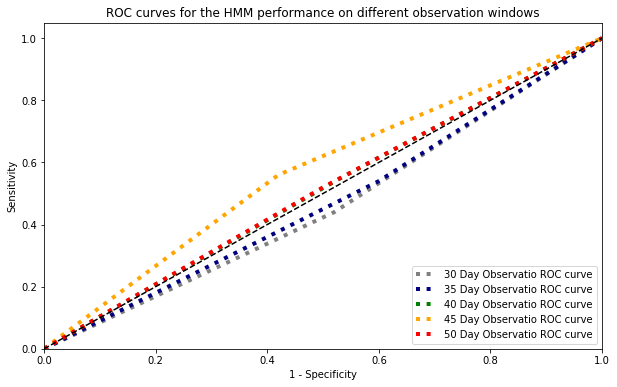

In [36]:
# Roc Curve
plt.figure(figsize=(10,6))
plt.plot(fpr_40, tpr_40,
         label='30 Day Observatio ROC curve',
         color='grey', linestyle=':', linewidth=4)

plt.plot(fpr_50, tpr_50,
         label='35 Day Observatio ROC curve',
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr_30, tpr_30,
         label='40 Day Observatio ROC curve',
         color='green', linestyle=':', linewidth=4)

plt.plot(fpr_35, tpr_35,
         label='45 Day Observatio ROC curve',
         color='orange', linestyle=':', linewidth=4)

plt.plot(fpr_45, tpr_45,
         label='50 Day Observatio ROC curve',
         color='red', linestyle=':', linewidth=4)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curves for the HMM performance on different observation windows')
plt.legend(loc="lower right")
plt.show()

In [139]:
K = 1
iters = 0;
past_likelihood = []
while iters < 3650 - K:
    past_likelihood = np.append(past_likelihood, model.score(np.flipud(testing[iters:iters + K])))
    iters = iters + 1

likelihood_diff_idx_1 = []
past_similar_test = []

for i in range(3650 - K - 1,0,-1):
    curr_likelihood = model.score(testing[i:i+K])
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    likelihood_diff_idx_1.append(likelihood_diff_idx+K+1)
    past_similar_test.append(rise_or_drop[likelihood_diff_idx+K+1])

cm = confusion_matrix(list(reversed(rise_or_drop))[0:200],past_similar_test[0:200])
accuracy1=(cm[0,0]+cm[1,1])/sum(sum(cm))
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])

y_test = list(reversed(rise_or_drop))[0:200]
y_test_score_ = past_similar_test[0:3000]

In [64]:
from scipy import stats

In [83]:
y_test = list(reversed(rise_or_drop))[0:3000]

In [89]:
df = pd.DataFrame(list(zip(y_test_score,y_test_score_30)), 
                  columns=['45 OB','30 OB'])

In [135]:
P_Value = []
T_Test = []

In [141]:

t_test, p_value = stats.mstats.ttest_ind(y_test_score,y_test_score_)
P_Value.append(p_value)
T_Test.append(t_test)
print("Testing Set: t_statistic is %0.3f and p-value is %0.6f"% (t_stat, p_value))

Testing Set: t_statistic is 0.026 and p-value is 0.016515


In [143]:
df = pd.DataFrame(list(zip(T_Test,P_Value)), 
                  columns=['t-test','p-value'])
df

,t-test,p-value
0,2.149791,0.031612
1,-2.791421,0.005264
2,-2.398016,0.016515
3,-2.398016,0.016515


In [84]:
#Calculate the t-test statistics and p-value for testing set
t_stat, p_value = stats.ttest_ind(y_test_score,y_test_score_30)
print("Testing Set: t_statistic is %0.3f and p-value is %0.6f"% (t_stat, p_value))

df = pd.DataFrame(list(zip(y_test_score,y_test_score_35)), 
                  columns=['45 OB','35 OB'])

#Calculate the t-train statistics and p-value for training set
t_stat, p_value = stats.ttest_ind(y_test_score,y_test_score_35)
print("training Set: t_statistic is %0.3f and p-value is %0.6f"% (t_stat, p_value))

df = pd.DataFrame(list(zip(y_test_score,y_test_score_40)), 
                  columns=['45 OB','40 OB'])

#Calculate the t-test statistics and p-value for testing set
t_stat, p_value = stats.ttest_ind(y_test_score,y_test_score_40)
print("Testing Set: t_statistic is %0.3f and p-value is %0.6f"% (t_stat, p_value))

df = pd.DataFrame(list(zip(y_test_score,y_test_score_50)), 
                  columns=['45 OB','50 OB'])

#Calculate the t-test statistics and p-value for testing set
t_stat, p_value = stats.ttest_ind(y_test_score,y_test_score_50)
print("Testing Set: t_statistic is %0.3f and p-value is %0.6f"% (t_stat, p_value))

Testing Set: t_statistic is 0.804 and p-value is 0.421509
training Set: t_statistic is -0.494 and p-value is 0.621664
Testing Set: t_statistic is 0.208 and p-value is 0.835553
Testing Set: t_statistic is 0.026 and p-value is 0.979294
